## Načítanie knižníc

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import re

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from nltk import pos_tag

## Načítanie dát

In [35]:
df_train = pd.read_csv('data/Twitter/twitter_training.csv')
df_test = pd.read_csv('data/Twitter/twitter_validation.csv')

df_train

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


## Predspracovanie dáta

#### Označenie stĺpcov

In [36]:
df_train.columns=['id','topic','target','tweet']
df_test.columns=['id','topic','target','tweet']

In [37]:
df_test.head()

,id,topic,target,tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...



#### Odstránenie irelevantných stĺpcov

In [38]:
df_train.drop(['id','topic'], axis=1, inplace=True)
df_test.drop(['id','topic'], axis=1, inplace=True)

#### Odstránenie chýbajúcich hodnôt

In [39]:
df_train.isna().sum()
df_train.dropna(inplace=True)

#### Odstránenie duplikátov

In [40]:
print(df_train.duplicated().sum())

4227


In [41]:
df_train.drop_duplicates(inplace=True)

#### Odstránenie špeciálnych znakov, prevedenie na malé písmo a odstránenie stop slov

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_train["cleaned_tweet"] = df_train["tweet"].apply(clean_text)
df_test["cleaned_tweet"] = df_test["tweet"].apply(clean_text)

#### Tokenizácia

In [ ]:
nltk.download("punkt_tab")

def tokenize_text(text):
    return word_tokenize(text)

df_train["tokenized_tweet"] = df_train["cleaned_tweet"].apply(tokenize_text)
df_test["tokenized_tweet"] = df_test["cleaned_tweet"].apply(tokenize_text)

#### Lematizácia

In [ ]:
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    return [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]

df_train["lemmatized_tweet"] = df_train["tokenized_tweet"].apply(lemmatize_text)
df_test["lemmatized_tweet"] = df_test["tokenized_tweet"].apply(lemmatize_text)

#### Enkódovanie cieľovej premennej

In [45]:
df_train["target"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [46]:
df_train["target"] = df_train["target"].map({"Positive": 0, "Neutral": 1,"Negative": 2, "Irrelevant": 3})
df_test["target"] = df_test["target"].map({"Positive": 0, "Neutral": 1,"Negative": 2, "Irrelevant": 3})

## Extrakcia príznakov


#### Vektorová reprezentácia pomocou TF-IDF

In [47]:
df_train["tf-idf_apply"] = df_train["lemmatized_tweet"].apply(lambda tokens: " ".join(tokens))
df_test["tf-idf_apply"] = df_test["lemmatized_tweet"].apply(lambda tokens: " ".join(tokens))

vectorizer = TfidfVectorizer(max_features=7500)
X_train = vectorizer.fit_transform(df_train["tf-idf_apply"])
X_test = vectorizer.transform(df_test["tf-idf_apply"])

y_train = df_train["target"]
y_test = df_test["target"]

In [48]:
df_train.head(10)

,target,tweet,cleaned_tweet,tokenized_tweet,lemmatized_tweet,tf-idf_apply
0,0,I am coming to the borders and I will kill you...,coming borders kill,"[coming, borders, kill]","[come, border, kill]",come border kill
1,0,im getting on borderlands and i will kill you ...,im getting borderlands kill,"[im, getting, borderlands, kill]","[im, get, borderland, kill]",im get borderland kill
2,0,im coming on borderlands and i will murder you...,im coming borderlands murder,"[im, coming, borderlands, murder]","[im, come, borderland, murder]",im come borderland murder
3,0,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,"[im, getting, borderlands, murder]","[im, get, borderland, murder]",im get borderland murder
4,0,im getting into borderlands and i can murder y...,im getting borderlands murder,"[im, getting, borderlands, murder]","[im, get, borderland, murder]",im get borderland murder
5,0,So I spent a few hours making something for fu...,spent hours making something fun dont know hug...,"[spent, hours, making, something, fun, dont, k...","[spent, hour, make, something, fun, dont, know...",spent hour make something fun dont know huge b...
6,0,So I spent a couple of hours doing something f...,spent couple hours something fun dont know im ...,"[spent, couple, hours, something, fun, dont, k...","[spent, couple, hour, something, fun, dont, kn...",spent couple hour something fun dont know im h...
7,0,So I spent a few hours doing something for fun...,spent hours something fun dont know im huge bo...,"[spent, hours, something, fun, dont, know, im,...","[spent, hour, something, fun, dont, know, im, ...",spent hour something fun dont know im huge bor...
8,0,So I spent a few hours making something for fu...,spent hours making something fun dont know hug...,"[spent, hours, making, something, fun, dont, k...","[spent, hour, make, something, fun, dont, know...",spent hour make something fun dont know huge r...
9,0,2010 So I spent a few hours making something f...,spent hours making something fun dont know hug...,"[spent, hours, making, something, fun, dont, k...","[spent, hour, make, something, fun, dont, know...",spent hour make something fun dont know huge r...


## Rozdelenie trénovacej sady na trénovaciu a validačnú

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

## Modelovanie

In [ ]:
logistic_regression = LogisticRegression()
naive_bayes = MultinomialNB()
svm = SVC()
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier()
xgboost_model = XGBClassifier()
decision_tree = DecisionTreeClassifier()

logistic_regression.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
svm.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
knn.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

models = (
    ("Logistic Regression", logistic_regression),
    ("Naive Bayes", naive_bayes),
    ("SVM", svm),
    ("Random Forest", random_forest),
    ("Decision Tree", decision_tree),
    ("KNN", knn),
    ("XGBoost", xgboost_model)
)

## Vyhodnotenie modelov

In [66]:
for name, model in models:
    y_pred = model.predict(X_test)
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_pred)}")

Logistic Regression Test Accuracy: 0.7927927927927928
Naive Bayes Test Accuracy: 0.7217217217217218
SVM Test Accuracy: 0.965965965965966
Random Forest Test Accuracy: 0.960960960960961
Decision Tree Test Accuracy: 0.9209209209209209
KNN Test Accuracy: 0.9379379379379379
XGBoost Test Accuracy: 0.7467467467467468


## Klasifikačná správa a vizualizácia matice zámen najlepších modelov

In [52]:
best_models = (
    ("SVM",svm),
    ("Random Forest", best_rf),
    ("KNN", best_knn)
)

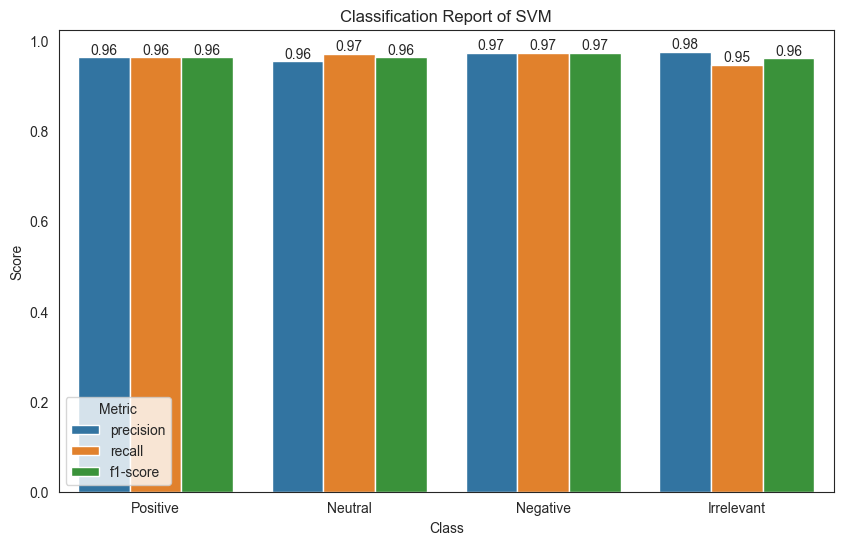

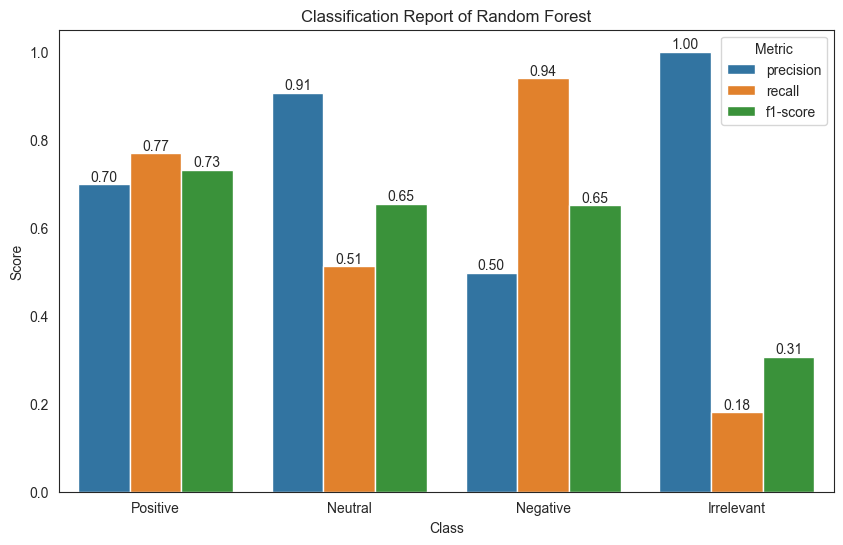

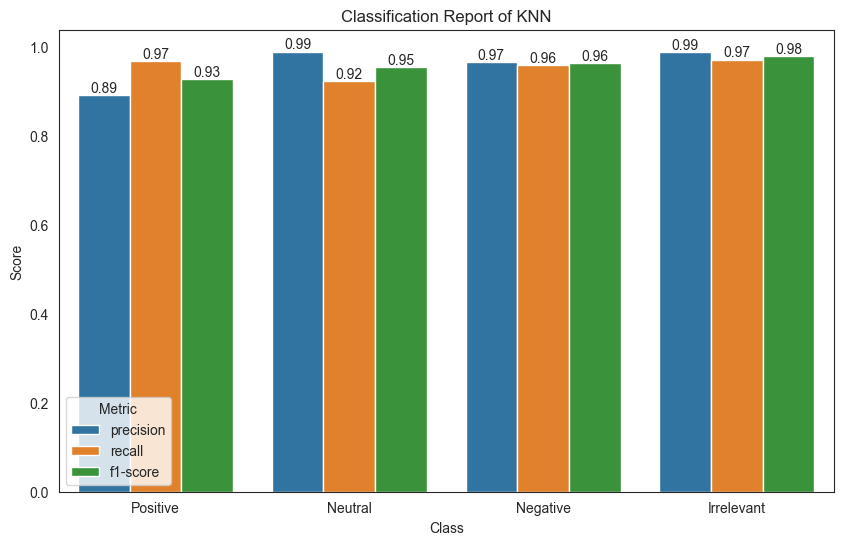

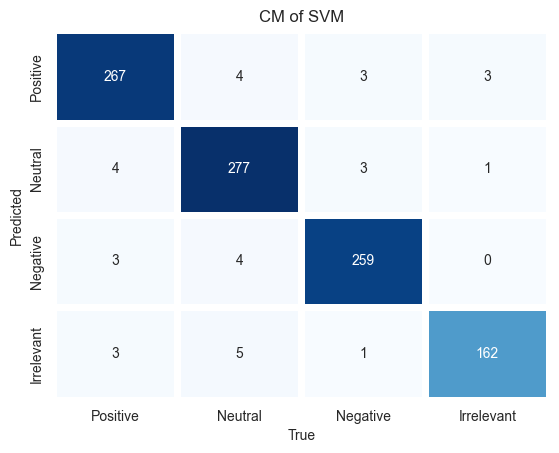

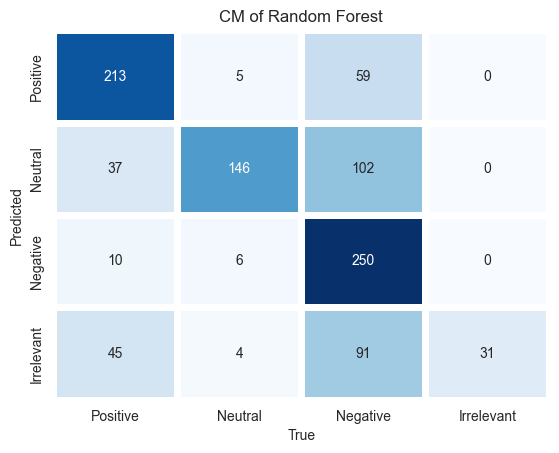

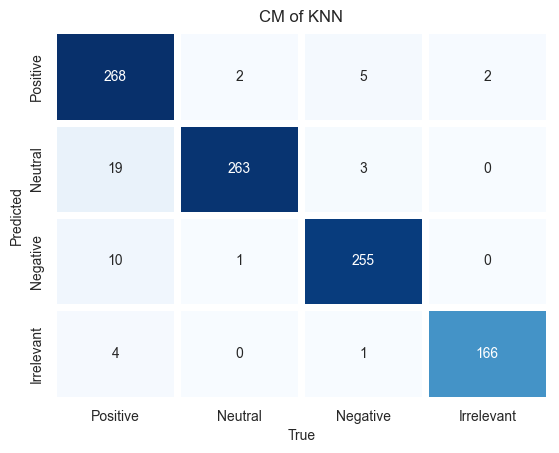

In [61]:
sns.set_style("white")

target_names = ["Positive", "Neutral", "Negative", "Irrelevant"]

for name, model in best_models:
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['accuracy', 'macro avg', 'weighted avg'])]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.title(f'Classification Report of {name}')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.show()

for name, model in best_models:
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, cmap='Blues', linewidths=5, fmt='d', xticklabels=target_names, yticklabels=target_names, cbar=False)
    plt.title(f'CM of {name}')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

## Testovanie na príkladoch

In [73]:
while True:
    example_string = input("Enter a text: ")
    if example_string.lower() == 'exit':
        break

    preprocessed_string = " ".join(lemmatize_text(tokenize_text(clean_text(example_string))))
    transformed_string = vectorizer.transform([preprocessed_string])

    prediction = svm.predict(transformed_string)

    label_map = {0: "Positive", 1: "Neutral", 2: "Negative", 3: "Irrelevant"}
    predicted_label = label_map[prediction[0]]

    print("Example string:", example_string)
    print("Predicted label:", predicted_label)

Example string: Very exciting game
Predicted label: Positive
Example string: This city is awful!!
Predicted label: Negative
Example string: Hello
Predicted label: Neutral
Example string: What about french toasts?
Predicted label: Positive


## Záver
abrakadabra abrakadabra abrakadabra 